In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

## Load the Dataset

In [2]:
url1 = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
url2 = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"

train = pd.read_csv(url1, sep="\t")
test = pd.read_csv(url2, sep="\t")

In [3]:
train.columns = ["sentence", "label"]
test.columns = ["sentence", "label"]

In [4]:
train

,sentence,label
0,apparently reassembled from the cutting room f...,0
1,they presume their audience wo n't sit still f...,0
2,this is a visually stunning rumination on love...,1
3,jonathan parker 's bartleby should have been t...,1
4,campanella gets the tone just right funny in t...,1
...,...,...
6914,"painful , horrifying and oppressively tragic ,...",1
6915,take care is nicely performed by a quintet of ...,0
6916,"the script covers huge , heavy topics in a bla...",0
6917,a seriously bad film with seriously warped log...,0


In [5]:
X_train, X_val, y_train, y_val = train_test_split(train["sentence"], train["label"], test_size=0.2, random_state=42)

## MLP Model

In [6]:
import torch
from torch import nn

In [7]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(10000, 2).to(device)

In [9]:
from torchinfo import summary

summary(model, input_size=(64, 10000))  # (batch_size, input_dim)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Linear: 2-1                       [64, 512]                 5,120,512
│    └─ReLU: 2-2                         [64, 512]                 --
│    └─Dropout: 2-3                      [64, 512]                 --
│    └─Linear: 2-4                       [64, 256]                 131,328
│    └─ReLU: 2-5                         [64, 256]                 --
│    └─Dropout: 2-6                      [64, 256]                 --
│    └─Linear: 2-7                       [64, 128]                 32,896
│    └─ReLU: 2-8                         [64, 128]                 --
│    └─Dropout: 2-9                      [64, 128]                 --
│    └─Linear: 2-10                      [64, 64]                  8,256
│    └─ReLU: 2-11                        [64, 64]                 

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import TensorDataset, DataLoader

In [11]:

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)  # 300 input_dim for MLP
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_val_vec = vectorizer.transform(X_val).toarray()

# Convert to tensors
X_train_tensor = torch.tensor(X_train_vec, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_vec, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
# Datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [12]:
test_vec = vectorizer.transform(test['sentence']).toarray()
X_test_tensor = torch.tensor(test_vec, dtype=torch.float32)
X_test_tensor_16= torch.tensor(test_vec, dtype=torch.float16)
y_test_tensor = torch.tensor(test['label'].values, dtype=torch.long)

## Training the model

In [13]:
import torch.optim as optim

# Hyperparameters
input_dim = 10000  # update this if using a different embedding size
output_dim = 2
num_epochs = 10
batch_size = 64
learning_rate = 0.001


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Trackers
best_val_acc = 0.0
train_losses, val_losses, val_accuracies = [], [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "checkpoint.pt")

Epoch 1/10 | Train Loss: 0.6191 | Val Loss: 0.4665 | Val Acc: 0.7775
Epoch 2/10 | Train Loss: 0.2714 | Val Loss: 0.5273 | Val Acc: 0.7825
Epoch 3/10 | Train Loss: 0.0817 | Val Loss: 0.7660 | Val Acc: 0.7681
Epoch 4/10 | Train Loss: 0.0196 | Val Loss: 1.1391 | Val Acc: 0.7572
Epoch 5/10 | Train Loss: 0.0071 | Val Loss: 1.4694 | Val Acc: 0.7608
Epoch 6/10 | Train Loss: 0.0060 | Val Loss: 1.5754 | Val Acc: 0.7616
Epoch 7/10 | Train Loss: 0.0016 | Val Loss: 1.8144 | Val Acc: 0.7572
Epoch 8/10 | Train Loss: 0.0007 | Val Loss: 1.9232 | Val Acc: 0.7616
Epoch 9/10 | Train Loss: 0.0005 | Val Loss: 2.1379 | Val Acc: 0.7630
Epoch 10/10 | Train Loss: 0.0003 | Val Loss: 2.4859 | Val Acc: 0.7478


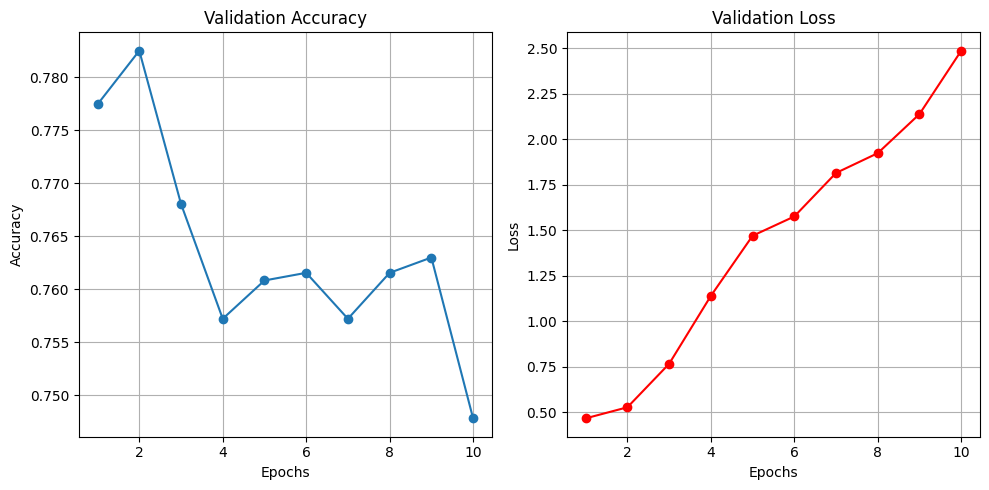

In [14]:
# Plotting
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_losses, marker='o', color='red', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
def evaluate_accuracy(model, features,labels):
    import time
    ###########################
    model.eval()
    model.to(device)
    features = features.to(device)
    labels = labels.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
    inference_time = time.time() - start_time
    
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    
    return accuracy, inference_time
    
    
    

In [16]:
def modelsize(model):
    import io
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    size = buffer.getbuffer().nbytes / (1024 * 1024)
    return size

In [17]:
model = MLP(10000, 2).to(device)
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()
size_original=modelsize(model)

acc_original,time_original = evaluate_accuracy(model, X_test_tensor, y_test_tensor)
print("Original Model Accuracy: {:.8f}%".format(acc_original * 100))
print("Original Model Inference Time: {:.4f} seconds".format(time_original))
print("Model size (MB):", size_original)

Original Model Accuracy: 79.17582418%
Original Model Inference Time: 0.0675 seconds
Model size (MB): 20.19481658935547


In [18]:
model = MLP(10000, 2).to(device)
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()
quantized_model = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

In [19]:
# For quantized model (must stay on CPU)
acc_int8,time_int8= evaluate_accuracy(quantized_model, X_test_tensor, y_test_tensor)
sizeint8=modelsize(quantized_model)

print("Quantized model accuracy: ", acc_int8*100, "%")
print("Quantized model inference time: {:.4f} seconds ".format(time_int8))
print("Quantized model size: ", sizeint8, "MB")

Quantized model accuracy:  79.23076923076923 %
Quantized model inference time: 0.0490 seconds 
Quantized model size:  5.057214736938477 MB


In [20]:
model = MLP(10000, 2).to(device)
model.load_state_dict(torch.load("checkpoint.pt"))
model=model.half()
model.eval()
acc_16,time_16 = evaluate_accuracy(model, X_test_tensor_16, y_test_tensor)
size16=modelsize(model)
print("Quantized model accuracy: ", acc_16*100, "%")
print("Model inference time (FP16): {:.4f} seconds".format(time_16))
print("Model size (MB):", size16)

Quantized model accuracy:  79.17582417582418 %
Model inference time (FP16): 0.4865 seconds
Model size (MB): 10.098991394042969


In [21]:
#make a dataframe with the results
import pandas as pd
d_original={"Model":"Original","accuracy":acc_original*100,"time":time_original,"size":size_original}
d_int8={"Model":"Dynamic","accuracy":acc_int8*100,"time":time_int8,"size":sizeint8}
d_half={"Model":"Half","accuracy":acc_16*100,"time":time_16,"size":size16}


In [22]:
columns=["Model","Accuracy","Time(in s)","Size in MB"]
df=pd.DataFrame(columns=columns)
df.loc[0]=d_original.values()
df.loc[1]=d_int8.values()
df.loc[2]=d_half.values()

In [23]:
df

,Model,Accuracy,Time(in s),Size in MB
0,Original,79.175824,0.067477,20.194817
1,Dynamic,79.230769,0.049037,5.057215
2,Half,79.175824,0.486474,10.098991
